# Word and Phrase Associations in CORD-19 Corpus
This notebook aims to explore associations between words and phrases using methods similar to [Tshitoyan et al., Nature 571, 95–98 (2019)](https://perssongroup.lbl.gov/papers/dagdelen-2019-word-embeddings.pdf). It heavily utilizes code from the [mat2vec github repo](https://github.com/materialsintelligence/mat2vec). The notebook includes:
* Loading, tokenizing, processing and saving the pre-processed text corpus (pre-processed dataset available).
* Training a phraser to find common phrases and training a word2vec model using the new vocab (pre-trained model available).
* Visualizing important connections between a set of words and phrases as a graph (e.g. "COVID-19" and "vitamin C").
* Uncovering terms with a strong connection to a specific keyword but never mentined together in the same paragraph (experimental, this should become more useful once an additional dataset with papers other than COVID-19 is added).
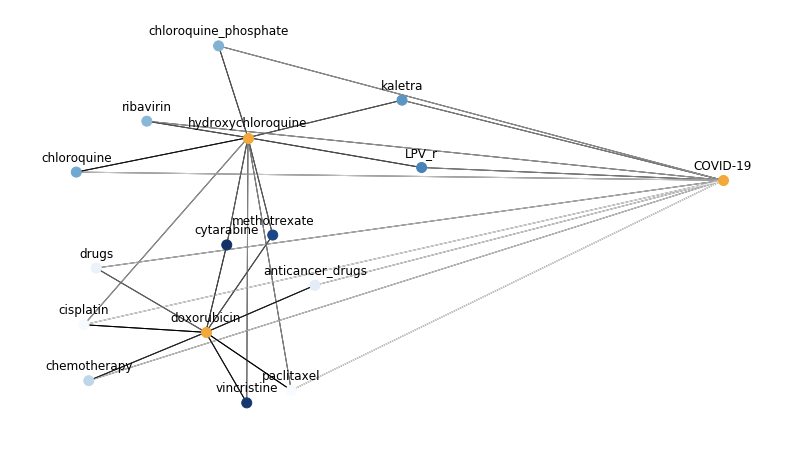

## Next steps
* Fine-tune a pre-trained word2vec model on biomedical text with covid-19 data
 * Tried on 2 of the more popular models and none of them were saved in a trainable state (http://bio.nlplab.org/, https://github.com/ncbi-nlp/BioSentVec). 
* There seems to be a fine-tuned BERT base available at https://huggingface.co/deepset/covid_bert_base. Try using this or similar BERT models for the same task.
* Get a larger biomedical text dataset, e.g. pubmed abstracts.
* Optimize the phrases and the word embeddings using a set of relevant analogies.
* Make a website for interactive exploration (e.g. graph nodes as links to the most relevant papers, etc.).

In [ ]:
import datetime
import itertools
import json
import os
import pickle
import regex
import time
import tqdm

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import plotly.express
import sklearn.manifold

import gensim.models
import nltk.tokenize

## Load and pre-process the data
You can either leave most of the variables unset to re-train everything from scratch, or supply some pre-processed and pre-trained file locations for faster execution and exploration. Leave it as is to use one of the pre-trained models.

In [ ]:
# Used to load raw articles. Only useful if the corpus needs to be processed and generated again.
data_root = '/kaggle/input/CORD-19-research-challenge'
folder_names = ['biorxiv_medrxiv', 'comm_use_subset', 'custom_license', 'noncomm_use_subset']

# Used to load the previously processed corpus and pre-trained models.
dataset_root = '/kaggle/input/covid19-research-corpus'
corpus_file = os.path.join(dataset_root, 'corpus')
pretrained_model = os.path.join(dataset_root,'w2v_1585759802.model')  # If not None, will use this model. Otherwise will train a new model.
pretrained_phraser = os.path.join(dataset_root, 'w2v_1585759802_phraser.pkl')  # If not None, will use a pre-trained phraser. Otherwise will build a new one.
phraser_depth = 1  # The depth of phrases. Match this with the pretrained phraser setting if it is supplied.

In [ ]:
NUM_TOK = '<nUm>'
NR_BASIC = regex.compile(r"^[+-]?\d*\.?\d+\(?\d*\)?+$", regex.DOTALL)
TOKENIZER_PATTERN = r'''(?x)                # set flag to allow verbose regexps
                        (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
                      | \d+(?:\.\d+)?       # numbers, incl. currency and percentages
                      | \w+(?:[-']\w+)*     # words w/ optional internal hyphens/apostrophe
                      | \.\.\.              # ellipsis
                      | [][.,$%;"'?():_`-]  # these are separate tokens; includes ], [
            '''


def is_number(s):
    """Determines if the supplied string is a number.

    Args:
        s: The input string.

    Returns:
        True if the supplied string is a number (both . and , are acceptable), False otherwise.
    """
    return NR_BASIC.match(s.replace(",", "")) is not None


def process_token(word, do_lowercase=True):
    """Pre-process a single token.
    
    Includes selective lowercasing to preserve abbreviations and
    converting all numbers to a special token.
    
    Args:
        word: The token.
        do_lowercase: If True, performs lowercasing.

    Returns:
        The pre-processed token.
    """
    if is_number(word):
        return NUM_TOK
    if do_lowercase:
        if len(word) == 1 or (len(word) > 1 and word[0].isupper() and word[1:].islower()):
            # Lowercase only if first letter alone is uppercase.
            return word.lower()
    return word
    

def tokenize_and_process(text):
    """Tokenizes and pre-processes a piece of text.
    
    Includes selective lowercasing to preserve abbreviations,
    as well as conversion of all numbers to special token <nUm>.
    
    Args:
        text: The text to tokenize.

    Returns:
        A sequence of pre-processed tokens.
    """
    tokens = nltk.tokenize.regexp_tokenize(text, pattern=TOKENIZER_PATTERN)
    return [process_token(token) for token in tokens]


json_roots = [os.path.join(data_root, folder_name, folder_name) for folder_name in folder_names]
def paragraph_generator():
    """Scans all json files in a directory and gets the content.
    
    Args:
        json_roots: The root folders of articles in json format.
        
    Yeilds:
        A paragraph as a string.
    """
    for json_root in json_roots:
        for filename in tqdm.tqdm(os.listdir(json_root)):
            # Load the json.
            with open(os.path.join(json_root, filename), 'r') as json_file:
                content = json.load(json_file)
            # Yeild the title.
            yield content['metadata']['title'].strip()
            # Yeild the text in abstract and full body.
            for section in ['abstract', 'body_text']:
                for paragraph in content[section]:
                    yield paragraph['text'].strip()

In [ ]:
# Pre-process and save a corpus if not supplied.
if corpus_file is None:
    if os.path.exists("corpus"):
        os.remove("corpus")
    with open('corpus', 'a+') as f:
        for p in paragraph_generator():
            f.write(' '.join(tokenize_and_process(p)) + '\n')
    corpus_file = 'corpus'

## Training


In [ ]:
# Utility functions to produce common phrases
COMMON_TERMS = ["-", "-", b"\xe2\x80\x93", b"'s", b"\xe2\x80\x99s", "from", "as", "at", "by", "of", "on",
                "into", "to", "than", "over", "in", "the", "a", "an", "/", "under"]
EXCLUDE_PUNCT = ["=", ".", ",", ":", "(", ")", "<", ">", "\"", "“", "”", "≥", "≤", "%", "$", ";", NUM_TOK]

def exclude_words(phrasegrams, words):
    """Given a list of words, excludes those from the keys of the phrase dictionary."""
    new_phrasergrams = {}
    words_re_list = []
    for word in words:
        we = regex.escape(word)
        words_re_list.append("^" + we + "$|^" + we + "_|_" + we + "$|_" + we + "_")
    word_reg = regex.compile(r""+"|".join(words_re_list))
    for gram in tqdm.tqdm(phrasegrams):
        valid = True
        for sub_gram in gram:
            if word_reg.search(sub_gram.decode("unicode_escape", "ignore")) is not None:
                valid = False
                break
            if not valid:
                continue
        if valid:
            new_phrasergrams[gram] = phrasegrams[gram]
    return new_phrasergrams


def wordgrams(sent, depth, pc, th, ct, et, d=0):
    """Produces a phraser for word n-grams."""
    if depth == 0:
        return sent, None
    else:
        phrases = gensim.models.phrases.Phrases(
            sent,
            common_terms=ct,
            min_count=pc,
            threshold=th)

        grams = gensim.models.phrases.Phraser(phrases)
        grams.phrasegrams = exclude_words(grams.phrasegrams, et)
        d += 1
        if d < depth:
            return wordgrams(grams[sent], depth, pc, th, ct, et, d)
        else:
            return grams[sent], grams

### Train a word2vec model

In [ ]:
class EpochLogger(gensim.models.callbacks.CallbackAny2Vec):
    """Callback to log information about training."""
    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print("{} Starting epoch #{}".format(
            datetime.datetime.now(), self.epoch))

    def on_epoch_end(self, model):
        print("{} Finished epoch #{}".format(
            datetime.datetime.now(), self.epoch))
        self.epoch += 1

if pretrained_model is not None:
    w2v_model = gensim.models.Word2Vec.load(pretrained_model)
    if pretrained_phraser is not None:
        with open(pretrained_phraser, 'rb') as f:
            phraser = pickle.load(f)
        sentences = gensim.models.word2vec.LineSentence(corpus_file)
        while phraser_depth > 0:
            sentences = phraser[sentences]
            phraser_depth -= 1
else:
    model_name = 'w2v_{}'.format(int(time.time()))
    if pretrained_phraser is None:
        print("{} Starting to build phrasegrams".format(
        datetime.datetime.now()))
        # Depth 1: 16 min.
        # Depth 2: 60 min.
        sentences, phraser = wordgrams(
            gensim.models.word2vec.LineSentence(corpus_file),
            depth=phraser_depth,
            pc=10,
            th=12.0,
            ct=COMMON_TERMS,
            et=EXCLUDE_PUNCT)
        phraser.save(os.path.join(model_name + "_phraser.pkl"))
        print("{} Finished building phrasegrams".format(
            datetime.datetime.now()))
    else:
        with open(pretrained_phraser, 'rb') as f:
            phraser = pickle.load(f)
        sentences = gensim.models.word2vec.LineSentence(corpus_file)
        while phraser_depth > 0:
            sentences = phraser[sentences]
            phraser_depth -= 1

    print("{} Init the word2vec model".format(datetime.datetime.now()))
    # Phrase depth 1
    # Before the 1st epoch starts (building vocab): 20 min.
    # Each epoch:                                   35 min.
    # Phrase depth 2
    # Before the 1st epoch starts (building vocab): 40 min.
    # Each epoch:                                   45 min.
    w2v_model = gensim.models.Word2Vec(
        sentences,
        size=200,
        window=8,
        min_count=10,
        sg=True,
        hs=False,
        alpha=0.01,
        sample=0.0001,
        negative=15,
        workers=4,
        sorted_vocab=True,
        callbacks=[EpochLogger()],
        iter=10)
    w2v_model.save(model_name + '.model')

## Exploration
### Visualize word embeddings

In [ ]:
keyword = 'COVID-19'
words_to_plot = 50

In [ ]:
# Find most similar words to the keyword and visualization using t-SNE.
top_words = [w for w, _ in w2v_model.wv.most_similar(keyword, topn=words_to_plot)] + [keyword]
print('Most similar words to \'{}\': '.format(keyword), top_words[:10])

dim_red = sklearn.manifold.TSNE(
    n_components=2, 
    perplexity=15.0, 
    n_iter=10000, 
    metric='cosine', 
    random_state=0)
top_words_2d = dim_red.fit_transform(w2v_model.wv[top_words])

fig = plotly.express.scatter(
    x=top_words_2d[:,0], 
    y=top_words_2d[:,1], 
    text=top_words,
    color=['blue'] * words_to_plot + ['orange'],
    color_discrete_map={'orange':'#ff8c00', 'blue':'#1f77b4'}
)
fig.update_traces(textposition='top center')
fig.update_layout(
    xaxis_showgrid=False, 
    yaxis_showgrid=False, 
    xaxis_zeroline=False, 
    yaxis_zeroline=False,
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    xaxis_showticklabels=False,
    yaxis_showticklabels=False,
    yaxis_title='',
    xaxis_title='',
    showlegend=False,
)
fig.show()

### Explore connections across a set of words / phrases

In [ ]:
KEYWORD_COLOR = 'orange'

def get_connecting_terms(words, model, topn=10, pairwise=False):
    """Gets topn connecting terms between the supplied list of words.
    
    Args:
        words: The list of words.
        model: The embedding model.
        topn: Number of connecting words to identify.
        pairwise: If true, will search for pairwise connections. Otherwise
            searches for words that connect all of the input words.
    """
    if len(words) > 5:
        raise ValueError('At most 5 words allowed, {} supplied.'.format(len(words)))
    if len(words) < 2:
        raise ValueError('At least 2 words required, {} supplied.'.format(len(words)))
    norm_syn1neg = w2v_model.trainables.syn1neg / np.linalg.norm(
        w2v_model.trainables.syn1neg, axis=1, keepdims=True)
    norm_word_vectors = model.wv[words] / np.linalg.norm(model.wv[words]  , axis=1, keepdims=True)
    
    top_words, similarities = {}, {}
    if pairwise:
        for idx1, idx2 in itertools.combinations(range(len(words)), 2):
            exclude_indices = [model.wv.vocab.get(words[idx1]).index,
                               model.wv.vocab.get(words[idx2]).index]
            scores_w1 = np.dot(norm_syn1neg, norm_word_vectors[idx1])
            scores_w2 = np.dot(norm_syn1neg, norm_word_vectors[idx2])
            scores = scores_w1 + scores_w2
            top_common_word_indices = np.argsort(scores)[::-1][:topn+2]
            top_common_word_indices = [i for i in top_common_word_indices if i not in exclude_indices][:topn]
            top_words[(words[idx1], words[idx2])] = (
                [w2v_model.wv.index2word[i] for i in top_common_word_indices],
                scores_w1[top_common_word_indices],
                scores_w2[top_common_word_indices],
            )
            similarities[(words[idx1], words[idx2])] = np.dot(norm_word_vectors[idx1], norm_word_vectors[idx2])
    else:
        exclude_indices = [model.wv.vocab.get(word).index for word in words]
        individual_scores = [np.dot(norm_syn1neg, norm_word_vectors[idx]) for idx, _ in enumerate(words)]
        scores = np.sum(individual_scores, axis=0)
        top_common_word_indices = np.argsort(scores)[::-1][:topn+2]
        top_common_word_indices = [i for i in top_common_word_indices if i not in exclude_indices][:topn]
        words_tuple = tuple(words)
        top_words[words_tuple] = tuple(
            [[w2v_model.wv.index2word[i] for i in top_common_word_indices]] + 
            [individual_score[top_common_word_indices] for individual_score in individual_scores],
        )
        similarities[words_tuple] = np.mean(
            [model.wv.similarity(w1, w2) for w1, w2 in itertools.combinations(words, 2)])
    return top_words, similarities

def graph_from_connecting_terms(graph_def):
    """Builds a graph using the output of get_connecting_terms."""
    G=nx.Graph()
    for keywords, connections in graph_def.items():
        G.add_nodes_from(keywords, color=KEYWORD_COLOR)
        for word_and_scores in zip(*connections):
            # Add the node with this connection word.
            connection_word = word_and_scores[0]
            G.add_node(connection_word, color=0)  # Color is adjusted later.
            # Add edges from this connection word to all 
            G.add_edges_from([
                (keywords[keyword_idx], connection_word, {'weight': keyword_score}) 
                for keyword_idx, keyword_score in enumerate(word_and_scores[1:])
            ])
    # Fix the colors for nodes with more than 2 edges.
    for node in G.nodes:
        if G.nodes[node]['color'] != KEYWORD_COLOR:
            all_weights = [G.edges[edge]['weight'] for edge in G.edges(node)]
            G.nodes[node]['color'] = sum(all_weights)
    return G

def plot_graph(G):
    """Plots the graph of connecting terms."""
    pos=nx.spring_layout(G)  # positions for all nodes.
    edge_weights = [nx.get_edge_attributes(G,'weight')[edge] for edge in G.edges]
    all_node_colors = nx.get_node_attributes(G, 'color')
    keyword_nodes = [node for node, color in all_node_colors.items() if color == KEYWORD_COLOR]
    node_colors, connection_nodes = zip(*[(all_node_colors[node], node) for node in G.nodes if node not in keyword_nodes])
    nx.draw(G, pos, nodelist=keyword_nodes, node_color=KEYWORD_COLOR, node_size = 100)
    nx.draw(G, pos, with_labels=False, nodelist=connection_nodes, node_size = 100,
            cmap=plt.cm.Blues, vmin=min(node_colors), vmax=max(node_colors), node_color=node_colors,
            edge_cmap=plt.cm.Greys, edge_vmin=min(edge_weights), edge_vmax=max(edge_weights), edge_color=edge_weights)
    # Plot the labels separately a little higher.
    pos_higher = {}
    all_pos_y = [v[1] for _, v in pos.items()]
    y_offset = 0.04 * (max(all_pos_y) - min(all_pos_y))
    for k, v in pos.items():
        pos_higher[k] = (v[0], v[1] + y_offset)
    nx.draw_networkx_labels(G, pos_higher, {n: n for n in G.nodes})
    
def plot_connection_graph(keywords, topn=10, pairwise=False):
    connecting_terms, similarities = get_connecting_terms(keywords, w2v_model, topn=topn, pairwise=pairwise)
    G = graph_from_connecting_terms(connecting_terms)
    plt.figure(figsize=(14, 12))
    plt.margins(0.1)
    plot_graph(G)
    print('Connecting words:')
    for keywords_and_connections in connecting_terms.items():
        keywords, connections = keywords_and_connections[0], keywords_and_connections[1]
        print(' >-< '.join(keywords) + ' (similarity {:.2f})'.format(similarities[keywords]), ':', connections[0])

### Interpreting the graphs
The orange nodes are the requested words, whereas the blue nodes are the words that connect them. The darker the blue node, the more it contributes to the connection of the requested words. This "connection strength" is determined by the sum of the weights of the edges connected to this node. The weight of the edge is given by the cosine similarity between the input and output embeddings of the two nodes it connects, represented also by the shade of the node. The darker the node, the larger it's weight. In a sense, the weight of the edge represents how likely the two nodes are to be mentioned close to each other in text.

In [ ]:
plot_connection_graph(['COVID-19', 'social', 'mental'], topn=10)

In [ ]:
plot_connection_graph(['COVID-19', 'treatment', 'effective'], topn=20)

In [ ]:
plot_connection_graph(['COVID-19', 'syndromes'], topn=20)

In [ ]:
plot_connection_graph(['COVID-19', 'medication', 'vitamin'], topn=10)

In [ ]:
plot_connection_graph(['COVID-19', 'hydroxychloroquine', 'doxorubicin'], topn=10)

### Identify hidden connections for a specific word / phrase [in development]
This should become more useful if the corpus / embeddings include terms not directly related to COVID-19.

In [ ]:
# A set of words mentioned together in the same paragraph
# This is used to search for explicit co-occurences of words.
# Takes several minutes.
word_sets = []
for i, sentence in enumerate(sentences):
    if i % 1000 == 0:
        print('Processed {} paragraphs.'.format(i), end='\r')
    word_sets.append(set(sentence))
print('Processed {} paragraphs.'.format(len(word_sets)))

In [ ]:
def get_hidden_connections(model, keyword,  nr_words=10, extra_words=None):
    """Return words that have close similarity but never mentioned with the keyword.
    
    This is done by combining word similarity with basic text search.
    
    Args:
        keywords: The keyword to search for, e.g. 'covid'
        nr_words: Number of hidden connections to return.
        extra_words: A set of words to search in addition to the keyword, that 
            would signify a known connection. These are usually synonyms of the
            keyword.
            
    Returns:
        A list of words connected to the keyword.
    """
    if keyword not in model.wv.vocab:
        raise ValueError('Word "{}" not in the vocabulary.'.format(keyword))
    connections = model.wv.most_similar(
        positive=[model.trainables.syn1neg[model.wv.vocab[keyword].index]],
        topn=5000,
    )
    hidden_connections = []
    search_words = {keyword}
    if extra_words is not None:
        search_words = search_words.union(extra_words)
    search_words = set(search_words)
    for i, (connection, _) in enumerate(connections):
        hidden = True  # Haven't found a match, still hidden
        for word_set in word_sets:
            if connection in word_set and search_words.intersection(word_set):
                # If they happen together, this is not an interesting word.
                hidden = False
                break
        if hidden:
            hidden_connections.append((connection, i))    
            if len(hidden_connections) == nr_words:
                return hidden_connections
    return hidden_connections

In [ ]:
# Change these to explore more.
keyword = 'COVID-19'
words_similar_to_keyword = ['nCoV', 'SARS-CoV-2', 'COVID', 'COVID-19_pneumonia', 'COVID-19_outbreak',
                            'novel_coronavirus', 'covid-19', 'wuhan', 'COVID-19_epidemic', 'SARS-Cov-2',
                            'COVID19', 'COVID-19_in_wuhan', 'COVID-2019', 'nCov', 'SARS', 'MERS']

hidden_connections = get_hidden_connections(
    w2v_model, keyword, nr_words=20, 
    extra_words=words_similar_to_keyword)
hidden_connections

In [ ]:
plot_connection_graph(['COVID-19', 'H18ps-H1ss', 'novel_S-OIV', 'MNM'], topn=10)